![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/academic/DeIdentification_Benchmarks_Text2Story2025/Deidentification_Performance_Comparison_Of_Healthcare_NLP_VS_Cloud_Solutions.ipynb)

# Comparing Medical Text De-Identification Performance: John Snow Labs, OpenAI, Anthropic Claude, Azure Health Data Services, and Amazon Comprehend Medical

This notebook presents a comparative analysis of de-identification solutions offered by Healthcare NLP library, OpenAI GPT-4o & GPT-4.5, Anthropic Claude 3.7 Sonnet, Azure Health Data Services, and Amazon Comprehend Medical. De-identification is a critical task in ensuring the privacy and security of Protected Health Information (PHI) in clinical data. In this analysis, we evaluate the performance of each solution in detecting PHI entities, using a benchmark dataset annotated by domain experts.

You can read the blogpost of this notebook here: https://medium.com/p/47f17d185c87

# Set Up

In [ ]:
!pip -q install azure-health-deidentification azure-identity openai anthropic boto3

Restart session may required.

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

In [ ]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 5.5.2
Spark NLP_JSL Version : 5.5.2


# Dataset

For the benchmark, we will use 48 open-source documents annotated by domain experts working at John Snow Labs. These annotations include the entities `IDNUM`, `LOCATION`, `DATE`, `AGE`, `NAME` and `CONTACT` Therefore, the benchmark will be conducted based on these labels.

**NOTE:** In this notebook, the results were prepared using the whole dataset, but a small part of it was shared. If you are interested in using the dataset, please contact us by sending email to **support@johnsnowlabs.com** 

In [1]:
# Downloading sample datasets.
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/deidentification_benchmark_ground_truth_10_doc.csv

In [ ]:
import pandas as pd
ground_truth_df = pd.read_csv("deidentification_benchmark_ground_truth_48_doc.csv")
ground_truth_df

,doc_id,text,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM
...,...,...,...,...,...,...
1474,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,568,Lake Erin,LOCATION
1475,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,LOCATION
1476,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,LOCATION
1477,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,CONTACT


In [ ]:
ground_truth_df.chunk_label.value_counts()

,count
chunk_label,
DATE,582
NAME,380
LOCATION,236
IDNUM,185
CONTACT,49
AGE,47


# Healthcare NLP

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("clinical_deidentification_docwise_benchmark", "en", "clinical/models")

clinical_deidentification_docwise_benchmark download started this may take some time.
Approx size to download 2.3 GB
[OK!]


In [ ]:
text_df = ground_truth_df[["doc_id", "text"]].drop_duplicates()
spark_df = spark.createDataFrame(text_df).repartition(32)
spark_df.show()

+------+--------------------+
|doc_id|                text|
+------+--------------------+
|    15|\n245096078\nFIH\...|
|    31|Legal Name:Page F...|
|    13|\n353101799\nPRGH...|
|    32|ED Evaluation Not...|
|    14|\n656434538 ELMVH...|
|    36|Pasco Bond DOB : ...|
|    17|\n533289709 YC\n2...|
|    34|Clinical Summary ...|
|    18|\n449637451\nFIH\...|
|     6|\n928175728 ELMVH...|
|     8|\n305265793\nFIH\...|
|     5|\n305265793\nFIH\...|
|    12|\n559197012\nFIH\...|
|     4|\n229937784\nFIH\...|
|    10|\n305265793\nFIH\...|
|     1|\n957770228\nFIH\...|
|     9|\n333145593\nFIH\...|
|     2|\n291181306\nFIH\...|
|     7|\n506243692\nFIH\...|
|     3|\n425093222\nPRGH...|
+------+--------------------+
only showing top 20 rows



In [ ]:
%%time

result = deid_pipeline.model.transform(spark_df)

res_df = result.select("doc_id", "text", F.explode(F.arrays_zip(result.ner_chunk.begin,
                                                                result.ner_chunk.end,
                                                                result.ner_chunk.result,
                                                                result.ner_chunk.metadata)).alias("cols")) \
               .select("doc_id", "text", F.expr("cols['0']").alias("begin"),
                                         F.expr("cols['1']").alias("end"),
                                         F.expr("cols['2']").alias("chunk"),
                                         F.expr("cols['3']['entity']").alias("chunk_label")
                      ).toPandas()

res_df = res_df.sort_values(["doc_id", "begin"]).reset_index(drop=True)
res_df.end = res_df.end+1
res_df

CPU times: user 1.03 s, sys: 199 ms, total: 1.22 s
Wall time: 2min 56s


,doc_id,text,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,1,10,957770228,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,11,14,FIH,LOCATION
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,15,22,0408267,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,23,33,46769/5v7d,NAME
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\n2/5/1994 12:00:00 AM\nTRACHEOESOPHAGEAL FISTULA .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n2-5-94\nDISCHARGE DATE :\n4-2-94\nPRIN...,34,40,237890,IDNUM
...,...,...,...,...,...,...
1521,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX SPECIALTY HEALTH CENTER\n\nCALIFORNIA Eupora ,\n\nRecords Coversheet\n\nDiego Foy\n\nPatient Name : 6...",564,568,Erin,LOCATION
1522,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX SPECIALTY HEALTH CENTER\n\nCALIFORNIA Eupora ,\n\nRecords Coversheet\n\nDiego Foy\n\nPatient Name : 6...",571,577,ALASKA,LOCATION
1523,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX SPECIALTY HEALTH CENTER\n\nCALIFORNIA Eupora ,\n\nRecords Coversheet\n\nDiego Foy\n\nPatient Name : 6...",578,583,38720,LOCATION
1524,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER\n\nNIX SPECIALTY HEALTH CENTER\n\nCALIFORNIA Eupora ,\n\nRecords Coversheet\n\nDiego Foy\n\nPatient Name : 6...",590,602,966.255.9888,CONTACT


In [ ]:
res_df.chunk_label.value_counts()

,count
chunk_label,
DATE,591
NAME,401
LOCATION,253
IDNUM,178
AGE,52
CONTACT,51


# Azure Health Data Services

In [ ]:
import os

CREDENTIALS_IN_JSON_FORMAT = {
"AZURE_CLIENT_ID":"", # update here with yours
"AZURE_TENANT_ID":"", # update here with yours
"AZURE_CLIENT_SECRET":"" # update here with yours
}
for k, v in CREDENTIALS_IN_JSON_FORMAT.items():
	os.environ[k] = v


# This is constant for one app setup
os.environ['AZURE_HEALTH_DEIDENTIFICATION_ENDPOINT'] = '' # update here

from azure.health.deidentification import DeidentificationClient
from azure.identity import DefaultAzureCredential
from azure.health.deidentification.models import *

endpoint = os.environ["AZURE_HEALTH_DEIDENTIFICATION_ENDPOINT"]
endpoint = endpoint.replace("https://", "")

credential = DefaultAzureCredential(exclude_interactive_browser_credential=False)

client = DeidentificationClient(endpoint, credential)
client

In [ ]:
%%time
import time

entity_col = []
azure_df = pd.DataFrame()
for i, row in ground_truth_df.drop_duplicates("text").iterrows():
    time.sleep(2)
    try:
        body = DeidentificationContent(input_text=row.text, operation="tag")
        result: DeidentificationResult = client.deidentify(body)

        entity_row = []
        begins = [entity.offset["codePoint"] for entity in result['taggerResult']["entities"]]
        ends = [entity.offset["codePoint"]+ entity.length["codePoint"] for entity in result['taggerResult']["entities"]]
        chunks = [entity.text for entity in result['taggerResult']["entities"]]
        chunk_labels = [(entity["category"]).upper() for entity in result['taggerResult']["entities"]]
        doc_ids = [row.doc_id]*len(begins)
        texts = [row.text]*len(begins)

        tmp_df = pd.DataFrame({"doc_id":doc_ids,
                       "text":texts,
                       "begin":begins,
                       "end":ends,
                       "chunk":chunks,
                       "chunk_label":chunk_labels
                      })

        azure_df = pd.concat([azure_df,tmp_df]).reset_index(drop=True)
    except:
        print(row.doc_id, "couldn't be processed...")

azure_df

CPU times: user 673 ms, sys: 73.5 ms, total: 747 ms
Wall time: 1min 48s


,doc_id,text,begin,end,chunk,chunk_label
0,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM
1,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,HOSPITAL
2,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM
3,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,28,46769,IDNUM
4,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,29,33,5v7d,IDNUM
...,...,...,...,...,...,...
1634,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,STATE
1635,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,ZIP
1636,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,598,966.255.,PHONE
1637,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",598,602,9888,FAX


In [ ]:
azure_df.chunk_label.value_counts()

,count
chunk_label,
DATE,617
DOCTOR,288
HOSPITAL,179
IDNUM,152
PATIENT,105
MEDICALRECORD,78
PHONE,54
AGE,49
STREET,25


We will map these labels to the ground truth labels.

In [ ]:
azure_df.chunk_label = azure_df.chunk_label.apply(lambda x: "LOCATION" if x in ['HOSPITAL', 'CITY', 'STATE', 'STREET', 'ZIP', 'LOCATIONOTHER', 'COUNTRYORREGION'] else x)
azure_df.chunk_label = azure_df.chunk_label.apply(lambda x: "IDNUM" if x in ['MEDICALRECORD', 'ACCOUNT', 'SOCIALSECURITY'] else x)
azure_df.chunk_label = azure_df.chunk_label.apply(lambda x: "NAME" if x in ['DOCTOR', 'PATIENT'] else x)
azure_df.chunk_label = azure_df.chunk_label.apply(lambda x: "CONTACT" if x in ['PHONE', 'EMAIL', 'FAX'] else x)
azure_df = azure_df[~azure_df.chunk_label.isin(["PROFESSION", "ORGANIZATION", "URL", "HEALTHPLAN", "USERNAME"])].reset_index(drop=True)
azure_df

,doc_id,text,begin,end,chunk,chunk_label
0,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM
1,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION
2,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM
3,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,28,46769,IDNUM
4,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,29,33,5v7d,IDNUM
...,...,...,...,...,...,...
1601,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,LOCATION
1602,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,LOCATION
1603,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,598,966.255.,CONTACT
1604,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",598,602,9888,CONTACT


In [ ]:
azure_df.chunk_label.value_counts()

,count
chunk_label,
DATE,617
NAME,393
LOCATION,253
IDNUM,231
CONTACT,63
AGE,49


# AWS Medical Comprehend

In [ ]:
import boto3
from botocore.client import Config

region_name = ""
AWS_ACCESS_KEY_ID = ""  # update here with yours
AWS_SECRET_ACCESS_KEY = "" # update here with yours

session = boto3.Session(aws_access_key_id=AWS_ACCESS_KEY_ID,
                        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                        region_name=region_name)

mfa_serial = "" # update here with yours

mfa_token = input('Please enter your 6 digit MFA code:')

sts = session.client('sts')

MFA_validated_token = sts.get_session_token(SerialNumber=mfa_serial, TokenCode=mfa_token)

config = Config(connect_timeout=3600, read_timeout=70)

In [ ]:
# Extract validated credentials for role assumption
validated_access_key_id = MFA_validated_token['Credentials']['AccessKeyId']
validated_secret_access_key = MFA_validated_token['Credentials']['SecretAccessKey']
validated_session_token = MFA_validated_token['Credentials']['SessionToken']

temp_sts_client = boto3.client(
    'sts',
    aws_access_key_id=validated_access_key_id,
    aws_secret_access_key=validated_secret_access_key,
    aws_session_token=validated_session_token
)

# choose your role
target_role_arn = "" # update here

# Assume the desired role
response = temp_sts_client.assume_role(
    RoleArn=target_role_arn,
    RoleSessionName='MedComp'
)

response

In [ ]:
import boto3
# temporary creds
tmp_access_key_id = response['Credentials']['AccessKeyId']
tmp_secret_access_key = response['Credentials']['SecretAccessKey']
tmp_session_token = response['Credentials']['SessionToken']


client = boto3.client(service_name='comprehendmedical',
                      region_name='', # update here
                      aws_access_key_id = tmp_access_key_id,
                      aws_secret_access_key = tmp_secret_access_key,
                      aws_session_token = tmp_session_token
                     )

In [ ]:
%%time

import boto3
import time

results = []
failed_chunk_ind = []

for index, row in ground_truth_df.drop_duplicates("text").iterrows():
    result = client.detect_phi(Text= row.text)
    results.append(result)

    # Sleep for 2 seconds
    time.sleep(2)

chunks = []
begins = []
ends = []
labels = []
ids = []
text_list = []
doc_ids = ground_truth_df.drop_duplicates("text").doc_id.to_list()
texts = ground_truth_df.drop_duplicates("text").text.to_list()

# Process the results
for text, doc_id, result in list(zip(texts, doc_ids, results)):

    if result['Entities'] != []:

        for entity in result['Entities']:

            chunks.append(entity['Text'])
            begins.append(entity['BeginOffset'])
            ends.append(entity['EndOffset'])
            labels.append(entity['Type'])
            ids.append(doc_id)
            text_list.append(text)

    else:
        failed_chunk_ind.append(doc_id)

aws_df = pd.DataFrame({"doc_id":ids, "text":text_lis, "begin":begins, "end":ends, "chunk":chunks, "chunk_label":labels})
aws_df

,doc_id,text,begin,end,chunk,chunk_label
0,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,ID
1,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,ID
2,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,28,46769,ID
3,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,ID
4,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,41,49,2/5/1994,DATE
...,...,...,...,...,...,...
1487,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",505,510,77-83,ID
1488,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",547,557,Jordanfort,NAME
1489,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,583,"Lake Erin , ALASKA 38720",ADDRESS
1490,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,PHONE_OR_FAX


In [ ]:
aws_df.chunk_label.value_counts()

,count
chunk_label,
DATE,571
NAME,333
ADDRESS,310
ID,175
AGE,44
PHONE_OR_FAX,40
PROFESSION,15
URL,2
EMAIL,2


We will map these labels to the ground truth labels.

In [ ]:
aws_df.chunk_label = aws_df.chunk_label.apply(lambda x: "LOCATION" if x == "ADDRESS" else x)
aws_df.chunk_label = aws_df.chunk_label.apply(lambda x: "IDNUM" if x == 'ID' else x)
aws_df.chunk_label = aws_df.chunk_label.apply(lambda x: "CONTACT" if x in ['PHONE_OR_FAX', 'EMAIL'] else x)
aws_df = aws_df[~aws_df.chunk_label.isin(["PROFESSION", "URL"])].reset_index(drop=True)
aws_df

,doc_id,text,begin,end,chunk,chunk_label
0,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM
1,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM
2,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,28,46769,IDNUM
3,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM
4,0,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,41,49,2/5/1994,DATE
...,...,...,...,...,...,...
1470,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",505,510,77-83,IDNUM
1471,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",547,557,Jordanfort,NAME
1472,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,583,"Lake Erin , ALASKA 38720",LOCATION
1473,47,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,CONTACT


In [ ]:
aws_df.chunk_label.value_counts()

,count
chunk_label,
DATE,571
NAME,333
LOCATION,310
IDNUM,175
AGE,44
CONTACT,42


# OpenAI 

## GPT-4o




In [ ]:
import openai
import json

# Set your OpenAI API key
openai.api_key = ""

# Define the prompt template for your task
def create_prompt(text):
    return f"""You are an expert medical annotator with extensive experience in labeling medical entities within clinical texts. Your role is to accurately identify and annotate Protected Health Information (PHI) entities in the provided text, following the specified entity types.

    ### Instructions:
    1. **Review the Text**: Carefully read the text to understand its medical context.
    2. **Identify PHI Entities**: Locate any terms or phrases that represent PHI, based on the following entity types:
    - IDNUM, LOCATION, DATE, AGE, NAME, CONTACT
    3. **Annotate Entities**: For each identified PHI, provide the start and end character indices, the entity type, and the exact text (chunk) of the entity.
    4. **Response Format**: Return the annotations in a structured JSON format, as demonstrated in the examples below.

    ### Example:

    **Input Sentence:**
    "MD Connect Call 11:59pm 2/16/69 from Dr. Hale at Senior Care Clinic Queen Creek, SD regarding Terri Bird."

    **Annotated Entities:**
    [
        {{'begin': 24, 'end': 30, 'entity_type': 'DATE', 'chunk': '2/16/69'}},
        {{'begin': 42, 'end': 45, 'entity_type': 'NAME', 'chunk': 'Hale'}},
        {{'begin': 50, 'end': 67, 'entity_type': 'LOCATION', 'chunk': 'Senior Care Clinic'}},
        {{'begin': 69, 'end': 79, 'entity_type': 'LOCATION', 'chunk': 'Queen Creek'}},
        {{'begin': 83, 'end': 84, 'entity_type': 'LOCATION', 'chunk': 'SD'}},
        {{'begin': 96, 'end': 105, 'entity_type': 'NAME', 'chunk': 'Terri Bird'}}
    ]

    ---

    ### Task:

    Extract all PHI entities from the text below. The entity types to identify are: **IDNUM, LOCATION, DATE, AGE, NAME, CONTACT**.

    **Expected Output Format:**
    {{
        entities:[
            {{'begin': <start_index>, 'end': <end_index>, 'entity_type': '<entity_type>', 'chunk': '<extracted_text>'}}
        ]
    }}

    ---

    ### Text to Annotate:

    {text}

    ---

    ### Your Response:
    """

def get_llm_inference(text, openai_model):
    try:
        # Create the prompt
        prompt = create_prompt(text)

        response = openai.chat.completions.create(
            model= openai_model,
            messages=[{"role": "system", "content": "You are an expert medical annotator with extensive experience in labeling PHI entities within clinical texts."},
                      {"role": "user", "content": prompt}],
            temperature=0
        )
        response_content = response.choices[0].message.content
        
        # Parse the response content to JSON format (assuming the response is in valid JSON format)
        entities = json.loads(response_content)["entities"]
        
        # Return the list of entities
        return entities
    except Exception as e:
        print(f"ERROR: {e}")
        return response


Getting predictions.

In [ ]:
import time

text_df = ground_truth_df[["doc_id", "text"]].drop_duplicates().reset_index(drop=True).copy()

# Create a new column for predictions initially filled with None or empty lists
text_df['predictions'] = None

# Iterate over each row with iterrows()
for index, row in text_df.iterrows():
    print("processing:",index)
    # Process each sentence using the inference function
    predictions = get_llm_inference(row['text'], 'gpt-4o')

    # Update the DataFrame with the prediction using .at
    text_df.at[index, 'predictions'] = predictions
    time.sleep(1)

Since there are issues with the begin-end indices coming from GPT-4o model, we will get the indices using the following code.

In [5]:
import re

def generate_start_end_index(text, word):
    try:
        word = re.escape(word)
        matches = re.finditer(r"\b" + word + r"\b", text)
        indexes = []
        for match in matches:
            try:
                start_index = match.start()
                end_index = match.end()
                indexes.append([start_index, end_index])
            except:
                indexes.append([])
        return indexes
    except Exception as e:
        print(f"generate_start_end_index function error {e}")
        return []

def get_list_of_entities(json_result, sentence):
    try:
        temp_list_of_entities = []
        text = sentence

        for item in json_result:
            try:
                temp_dict = dict()
                temp_dict['entity_type'] = item['entity_type']
                word = temp_dict['chunk'] = item['chunk']
                index_list_of_same_chunks = [x['begin-end'] for x in temp_list_of_entities if x['entity_type'] == item['entity_type'] and word == x['chunk']]
                if len(index_list_of_same_chunks) > 0:
                    last_index = max(index_list_of_same_chunks, key=lambda x: x[1])
                    if last_index is not None and word in text[last_index[1]:]:
                        start_index = last_index[1] + text[last_index[1]:].index(word)
                    else:
                        start_index = text.find(word)
                    end_index = start_index + len(word)
                    temp_dict['begin-end'] = [start_index, end_index]
                else:
                    temp_dict['begin-end'] = generate_start_end_index(text, word)
                if temp_dict['begin-end'] != []:
                    temp_list_of_entities.append(temp_dict)
            except:
                pass
        return temp_list_of_entities
    except Exception as e:
        print(f"ERROR: {e}")
        return []

def flatten_predictions(predictions):
    flattened = []
    for item in predictions:
        # Extract data from each item
        entity_type = item['entity_type']
        chunk = item['chunk']
        begin_end_list = item['begin-end']

        # Create a new dictionary for each begin-end pair and add to the flattened list
        for begin_end in begin_end_list:
            new_item = {
                'entity_type': entity_type,
                'chunk': chunk,
                'begin-end': begin_end  # Each new item will have only one pair of indices
            }
            flattened.append(new_item)

    return flattened

def get_result_df (row):
    data = row.predictions_w_index
    doc_id = row.doc_id
    text = row.text

    # Transform the data into the desired DataFrame format
    res_df = pd.DataFrame([{
        'begin': item['begin-end'][0],
        'end': item['begin-end'][1],
        'chunk': item['chunk'],
        'entity_type': item['entity_type']
    } for item in data])

    res_df["doc_id"] = doc_id
    res_df["text"] = text
    res_df = res_df[["doc_id", "text", 'begin', 'end', "chunk", "entity_type"]]
    return res_df


In [ ]:
text_df['predictions_w_index'] = text_df.apply(lambda x: get_list_of_entities(x['predictions'], x['text']), axis=1)
text_df['predictions_w_index'] = text_df['predictions_w_index'].apply(flatten_predictions)
gpt_df = pd.concat(text_df.apply(get_result_df, axis=1).tolist(), ignore_index=True)
gpt_df.rename(columns={"entity_type":"chunk_label"}, inplace=True)

gpt_df

,doc_id,text,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,IDNUM
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM
...,...,...,...,...,...,...
1483,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,568,Lake Erin,LOCATION
1484,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,LOCATION
1485,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,IDNUM
1486,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,CONTACT


In [ ]:
gpt_df.chunk_label.value_counts()

,count
chunk_label,
DATE,566
NAME,391
IDNUM,234
LOCATION,183
AGE,63
CONTACT,51


## GPT-4.5

In [ ]:
import time

text_df = ground_truth_df[["doc_id", "text"]].drop_duplicates().reset_index(drop=True).copy()

# Create a new column for predictions initially filled with None or empty lists
text_df['predictions'] = None

# Iterate over each row with iterrows()
for index, row in text_df.iterrows():
    print("processing:",index)
    # Process each sentence using the inference function
    predictions = get_llm_inference(row['text'], 'gpt-4.5-preview')

    # Update the DataFrame with the prediction using .at
    text_df.at[index, 'predictions'] = predictions
    time.sleep(1)

In [ ]:
text_df['predictions_w_index'] = text_df.apply(lambda x: get_list_of_entities(x['predictions'], x['text']), axis=1)
text_df['predictions_w_index'] = text_df['predictions_w_index'].apply(flatten_predictions)
gpt_45_df = pd.concat(text_df.apply(get_result_df, axis=1).tolist(), ignore_index=True)
gpt_45_df.rename(columns={"entity_type":"chunk_label"}, inplace=True)

gpt_45_df

,text,begin,end,chunk,chunk_label
0,\n059140531 ELMVH\n47793532\n6601693\n1/24/200...,1,10,059140531,IDNUM
0,\n059140531 ELMVH\n47793532\n6601693\n1/24/200...,11,16,ELMVH,LOCATION
0,\n059140531 ELMVH\n47793532\n6601693\n1/24/200...,17,25,47793532,IDNUM
0,\n059140531 ELMVH\n47793532\n6601693\n1/24/200...,26,33,6601693,IDNUM
0,\n059140531 ELMVH\n47793532\n6601693\n1/24/200...,34,55,1/24/2004 12:00:00 AM,DATE
...,...,...,...,...,...
46,critical result hand delivered to manual self ...,667,673,ivo rn,NAME
46,critical result hand delivered to manual self ...,679,692,arthor billet,NAME
46,critical result hand delivered to manual self ...,696,708,laurice pope,NAME
46,critical result hand delivered to manual self ...,712,722,27 07 2022,DATE


In [ ]:
gpt_45_df.chunk_label.value_counts()

chunk_label
DATE        607
NAME        418
IDNUM       201
LOCATION    162
AGE          55
CONTACT      43
Name: count, dtype: int64

## Anthropic Claude 3.7 Sonnet

In [ ]:
def get_prompt(text):
    prompt = f"""
    You are an expert medical annotator with extensive experience in labeling medical entities within clinical texts. Your role is to accurately identify and annotate Protected Health Information (PHI) entities in the provided text, following the specified entity types.

    ### Instructions:
    1. **Review the Text**: Carefully read the text to understand its medical context.
    2. **Identify PHI Entities**: Locate any terms or phrases that represent PHI, based on the following entity types:
    - IDNUM, LOCATION, DATE, AGE, NAME, CONTACT
    3. **Annotate Entities**: For each identified PHI, provide the start and end character indices, the entity type, and the exact text (chunk) of the entity.
    4. **Response Format**: Return the annotations in a structured JSON format, as demonstrated in the examples below.
    5. DO NOT return any other text or explanation like 'Here is the entities..' or 'JSON:...'.
    
    ### Example:

    **Input Sentence:**
    "MD Connect Call 11:59pm 2/16/69 from Dr. Hale at Senior Care Clinic Queen Creek, SD regarding Terri Bird."

    **Annotated Entities:**
    [
        {{'begin': 24, 'end': 30, 'entity_type': 'DATE', 'chunk': '2/16/69'}},
        {{'begin': 42, 'end': 45, 'entity_type': 'NAME', 'chunk': 'Hale'}},
        {{'begin': 50, 'end': 67, 'entity_type': 'LOCATION', 'chunk': 'Senior Care Clinic'}},
        {{'begin': 69, 'end': 79, 'entity_type': 'LOCATION', 'chunk': 'Queen Creek'}},
        {{'begin': 83, 'end': 84, 'entity_type': 'LOCATION', 'chunk': 'SD'}},
        {{'begin': 96, 'end': 105, 'entity_type': 'NAME', 'chunk': 'Terri Bird'}}
    ]

    ---

    ### Task:

    Extract all PHI entities from the text below. DO NOT return any other text or explanation like 'Here is the entities..'. The ONLY PHI entity types to identify are: **IDNUM, LOCATION, DATE, AGE, NAME, CONTACT**. 

    Expected Output Format:
    {{
        entities:[
            {{'begin': <start_index>, 'end': <end_index>, 'entity_type': '<entity_type>', 'chunk': '<extracted_text>'}}
        ]
    }}

    ---

    ### Text to Annotate:

    {text}

    ---

    ### Your Response:
    """

    return prompt

In [ ]:
import anthropic

# Initialize the Anthropic client
client = anthropic.Anthropic(api_key="") # Claude API key

def get_prediction(text):
    prompt = get_prompt(text)

    # Call Claude 3.7 Sonnet API
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",  # Specify Claude 3 Sonnet model
        max_tokens=5000,  # Adjust as needed
        messages=[{"role": "user", "content": prompt}]
    )

    return response

In [ ]:
import json, time

claude_text_df = ground_truth_df[["doc_id", "text"]].drop_duplicates().reset_index(drop=True).copy()
claude_text_df["predictions"] = None
responses = []
ind=0

for doc_id, text in list(zip(claude_text_df.doc_id, text_df.text)):
    try:
        response = get_prediction(text)
        json_string = response.content[0].text
        data_dict = json.loads(json_string)["entities"]
        claude_text_df.at[ind, "entities"] = data_dict
        ind+=1
        time.sleep(2)

    except Exception as e:
        print("Error:", doc_id)
        print(response)
        print(e)
        break

Although we mentioned the labels in the prompt, the Claude 3.7 Sonnet model returned some additional labels such as `TIME`. Therefore, we will exclude these labels.

Also we encountered the same indexing issue with Anthropic Claude 3.7 Sonnet, it doesn't return the begin-end indices correctly. So we resolved it using the same approach we applied to the GPT-4o results.

In [6]:
claude_text_df['predictions_w_index'] = claude_text_df.apply(lambda x: get_list_of_entities(x['predictions'], x['text']), axis=1)
claude_text_df['predictions_w_index'] = claude_text_df['predictions_w_index'].apply(flatten_predictions)
claude_df = pd.concat(claude_text_df.apply(get_result_df, axis=1).tolist(), ignore_index=True)
claude_df.rename(columns={"entity_type":"chunk_label"}, inplace=True)

# only 'IDNUM', 'DATE', 'AGE', 'LOCATION', 'NAME', 'CONTACT' labels 
claude_df = claude_df[claude_df.chunk_label != "TIME"].reset_index(drop=True)
claude_df

,doc_id,text,begin,end,chunk,chunk_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,41,61,2/5/1994 12:00:00 AM,DATE
...,...,...,...,...,...,...
1627,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,568,Lake Erin,LOCATION
1628,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,LOCATION
1629,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,IDNUM
1630,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,CONTACT


In [7]:
claude_df.chunk_label.value_counts()

chunk_label
DATE        584
NAME        412
LOCATION    276
IDNUM       257
AGE          62
CONTACT      41
Name: count, dtype: int64

### Chunk-Level Evaluation: PHI Entity Prediction Matching Comparison

The **`eval_chunk_base`** function is designed to compare two DataFrames (df1 and df2) that contain information about identified chunks of text, likely in the context of Named Entity Recognition (NER) or de-identification. It aims to determine how well the chunks identified in df2 match the chunks in df1 (which is likely the ground truth).

**1. Comparing Chunks:**

The inner loop for n, m in tmp_df.iterrows(): iterates through each row (m) of the filtered df2 (i.e., chunks in the same document).

- **Full Match:** The first if condition checks if the chunk, begin, and end values in df1 and df2 are identical. If they are, it means there's a full match, and the function records "`full_match`" and the predicted label (`m.chunk_label`) from df2.

- **Partial Match**: The elif condition checks for various scenarios of partial overlap between the chunks based on their begin and end values. If any of these conditions are true, it means there's a partial match, and the function records "`partial_match`" and the predicted label.

- **Not Matched:** If none of the above conditions are true, it means the chunk in df1 was not found in df2, so the function records "`not_matched`" and "`no_prediction`".

**2. Appending Results:**

After comparing the chunk in df1 with all chunks in the filtered df2, the match_result and predictions lists are updated with the results.

**3. Returning Results:**

Finally, the function returns the `match_result` and `predictions` lists.

In [9]:
def eval_chunk_base(df1, df2):

    match_result = []
    predictions = []

    for j,i in df1.iterrows():
        tmp_df = df2[df2.text==i.text]
        for n,m in tmp_df.iterrows():
            if ((i.chunk == m.chunk) & (i.begin == m.begin) & (i.end == m.end)):
                match = "full_match"
                pred = m.chunk_label
                break

            elif ((i.begin == m.begin) & (i.end != m.end)) |\
                 ((i.begin != m.begin) & (i.end == m.end)) |\
                 ((i.begin < m.begin) & (i.end > m.end)) |\
                 ((i.begin > m.begin) & (i.end < m.end)) |\
                 ((i.begin < m.begin) & ((i.end < m.end) & (i.end > m.begin))) |\
                 (((i.begin > m.begin) & (i.begin < m.end)) & (i.end > m.end))   :

                match = "partial_match"
                pred = m.chunk_label
                break

            else:
                match = "not_matched"
                pred = "no_prediction"

        match_result.append(match)
        predictions.append(pred)

    return match_result, predictions

In [ ]:
ground_truth_df["healthcare_nlp_is_matched"], ground_truth_df["healthcare_nlp_prediction"]  = eval_chunk_base(ground_truth_df, res_df)
ground_truth_df["azure_is_matched"], ground_truth_df["azure_prediction"]  = eval_chunk_base(ground_truth_df, azure_df)
ground_truth_df["aws_is_matched"], ground_truth_df["aws_prediction"]  = eval_chunk_base(ground_truth_df, aws_df)
ground_truth_df["gpt4_is_matched"], ground_truth_df["gpt4_prediction"]  = eval_chunk_base(ground_truth_df, gpt_df)
ground_truth_df["claude_is_matched"], ground_truth_df["claude_prediction"]  = eval_chunk_base(ground_truth_df, claude_df)
ground_truth_df["gpt45_is_matched"], ground_truth_df["gpt45_prediction"]  = eval_chunk_base(ground_truth_df, gpt_45_df)

ground_truth_df

,doc_id,text,begin,end,chunk,chunk_label,healthcare_nlp_is_matched,healthcare_nlp_prediction,azure_is_matched,azure_prediction,aws_is_matched,aws_prediction,gpt4_is_matched,gpt4_prediction,claude_is_matched,claude_prediction,gpt45_is_matched,gpt45_prediction
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION,full_match,LOCATION,full_match,LOCATION,not_matched,no_prediction,full_match,IDNUM,not_matched,no_prediction,not_matched,no_prediction
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM,full_match,NAME,partial_match,IDNUM,partial_match,IDNUM,full_match,IDNUM,full_match,IDNUM,not_matched,no_prediction
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",559,568,Lake Erin,LOCATION,partial_match,LOCATION,full_match,LOCATION,partial_match,LOCATION,full_match,LOCATION,full_match,LOCATION,full_match,LOCATION
1475,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",571,577,ALASKA,LOCATION,full_match,LOCATION,full_match,LOCATION,partial_match,LOCATION,full_match,LOCATION,full_match,LOCATION,full_match,LOCATION
1476,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",578,583,38720,LOCATION,full_match,LOCATION,full_match,LOCATION,partial_match,LOCATION,full_match,IDNUM,full_match,IDNUM,full_match,IDNUM
1477,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",590,602,966.255.9888,CONTACT,full_match,CONTACT,partial_match,CONTACT,full_match,CONTACT,full_match,CONTACT,full_match,CONTACT,full_match,CONTACT


Let's visualize the predictions of all tools on a single plot, displaying their matching percentage results.

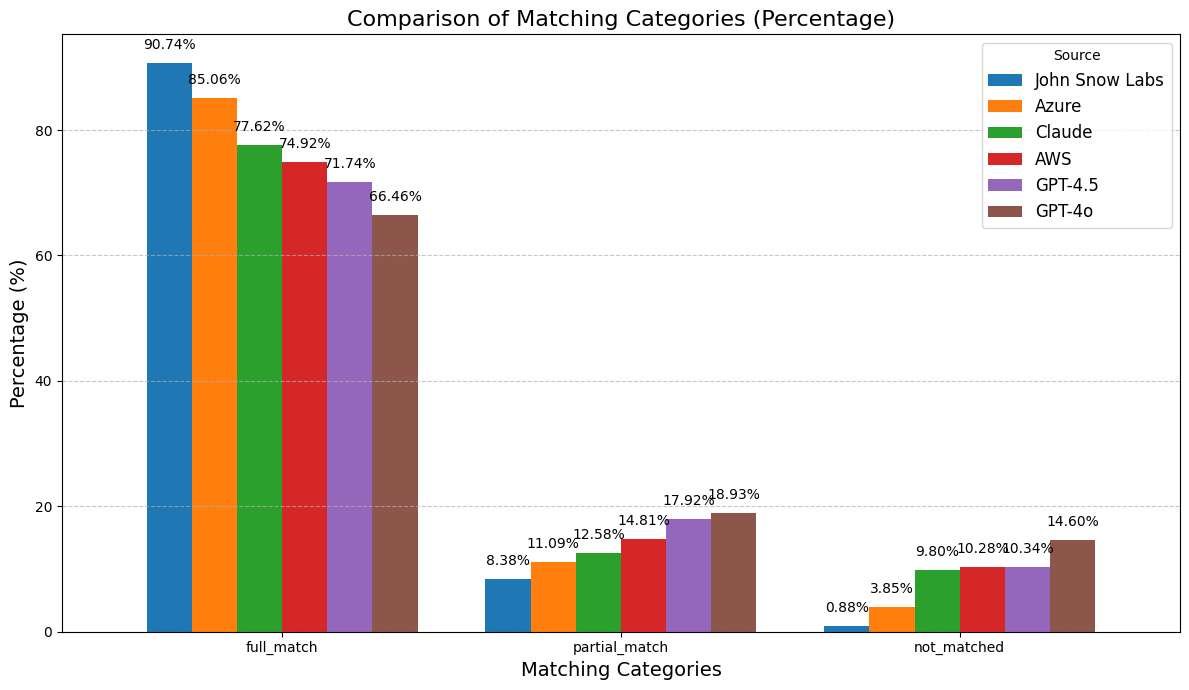

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Calculate value counts for each column
jsl_counts = ground_truth_df['john_snow_labs_is_matched'].value_counts()
azure_counts = ground_truth_df['azure_is_matched'].value_counts()
aws_counts = ground_truth_df['aws_is_matched'].value_counts() 
gpt_counts = ground_truth_df['gpt4_is_matched'].value_counts()
claude_counts = ground_truth_df['claude_is_matched'].value_counts()
gpt45_counts = ground_truth_df['gpt45_is_matched'].value_counts()

# Normalize counts to percentages
jsl_percentage = jsl_counts / jsl_counts.sum() * 100
azure_percentage = azure_counts / azure_counts.sum() * 100
aws_percentage = aws_counts / aws_counts.sum() * 100
gpt_percentage = gpt_counts / gpt_counts.sum() * 100
claude_percentage = claude_counts / claude_counts.sum() * 100
gpt45_percentage = gpt45_counts / gpt45_counts.sum() * 100


# Combine into a single DataFrame
value_counts_df = pd.DataFrame({
    'John Snow Labs': jsl_percentage,
    'Azure': azure_percentage,
    'Claude': claude_percentage,
    'AWS': aws_percentage,
    'GPT-4.5': gpt45_percentage,
    'GPT-4o': gpt_percentage
}).fillna(0)  # Fill missing values with 0

# Plot grouped bar chart
ax = value_counts_df.plot(kind='bar', figsize=(12, 7), width=0.8)

# Customize plot
plt.title('Comparison of Matching Categories (Percentage)', fontsize=16)
plt.xlabel('Matching Categories', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=0)  # Keep labels horizontal
plt.legend(title='Source', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 8),  # 8 points vertical offset
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

# Token Level Evaluation

We will tokenize the texts and then add labels from each predictions.

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer
        ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

In [ ]:
sdf_result = model.transform(spark_df)

token_pred_df = sdf_result.select("doc_id", "text", F.explode(F.arrays_zip(sdf_result.token.begin,
                                                                           sdf_result.token.end,
                                                                           sdf_result.token.result,
                                                                          )).alias("cols"))\
                          .select("doc_id", "text", F.expr("cols['0']").alias("token_begin"),
                                                    F.expr("cols['1']").alias("token_end"),
                                                    F.expr("cols['2']").alias("token")).toPandas()

# aling end indexes with prediction indexes
token_pred_df.token_end = token_pred_df.token_end + 1
token_pred_df

,doc_id,text,token_begin,token_end,token
0,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,1,10,245096078
1,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,11,14,FIH
2,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,15,22,9174858
3,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,23,34,12/February
4,15,\n245096078\nFIH\n9174858\n12/February\n997359\n11/3/1992 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n11/3/92\nDISCHARGE DATE :\n12/6/92\nHISTORY OF...,35,41,997359
...,...,...,...,...,...
45167,35,"Patient Summary :\n\nORLANDO VETERANS AFFAIRS MEDICAL CENTER\n\n420 W Magnetic\n\nCANAGA , NEW MEXICO 18288-5119\n\nBring This After Hospital Care Plan To ALL Appointments\n\nAfter Hospital Care P...",10112,10113,(
45168,35,"Patient Summary :\n\nORLANDO VETERANS AFFAIRS MEDICAL CENTER\n\n420 W Magnetic\n\nCANAGA , NEW MEXICO 18288-5119\n\nBring This After Hospital Care Plan To ALL Appointments\n\nAfter Hospital Care P...",10114,10116,on
45169,35,"Patient Summary :\n\nORLANDO VETERANS AFFAIRS MEDICAL CENTER\n\n420 W Magnetic\n\nCANAGA , NEW MEXICO 18288-5119\n\nBring This After Hospital Care Plan To ALL Appointments\n\nAfter Hospital Care P...",10117,10127,24/07/2024
45170,35,"Patient Summary :\n\nORLANDO VETERANS AFFAIRS MEDICAL CENTER\n\n420 W Magnetic\n\nCANAGA , NEW MEXICO 18288-5119\n\nBring This After Hospital Care Plan To ALL Appointments\n\nAfter Hospital Care P...",10128,10133,18:30


### Add Token Labels

This code assigns chunk labels from four different sources (`ground_truth_df`, `res_df`, `azure_df`, `aws_df`, `claude_df`, `gpt_df`) to tokens in `token_pred_df`. It determines which chunk label a token belongs to based on its begin position falling within the begin and end range of a chunk.

After the function executes:

The lists `gt_token_labels`, `deid_token_labels`, `azure_token_labels`, `aws_token_labels`, `claude_token_labels`, and `gpt4_token_labels` contain the corresponding chunk labels for each token in `token_pred_df`.




In [ ]:
%%time
from tqdm import tqdm

gt_token_labels = []
deid_token_labels = []
azure_token_labels = []
aws_token_labels = []
gpt_token_labels = []
gpt_45_token_labels = []
claude_token_labels = []
docs = token_pred_df.text.unique()

for doc in tqdm(docs):
    gt_slice_df = ground_truth_df[ground_truth_df.text==doc].copy()
    deid_slice_df = res_df[res_df.text==doc].copy()
    azure_slice_df = azure_df[azure_df.text==doc].copy()
    aws_slice_df = aws_df[aws_df.text==doc].copy()
    gpt_slice_df = gpt_df[gpt_df.text==doc].copy()
    claude_slice_df = claude_df[claude_df.text==doc].copy()
    token_slice_df = token_pred_df[token_pred_df.text==doc].copy()

    for token_ind, token_row in token_slice_df.iterrows():
        # gt
        token_label="O"
        for gt_ind, gt_row in gt_slice_df.iterrows():
            if (gt_row.begin <=token_row.token_begin < gt_row.end):
                token_label = gt_row.chunk_label
                break
            else:
                pass
        gt_token_labels.append(token_label)

        # deid
        deid_label="O"
        for deid_ind, deid_row in deid_slice_df.iterrows():
            if (deid_row.begin <= token_row.token_begin < deid_row.end):
                deid_label = deid_row.chunk_label
                break
            else:
                pass
        deid_token_labels.append(deid_label)

        # azure
        azure_label="O"
        for azure_ind, azure_row in azure_slice_df.iterrows():
            if (azure_row.begin <= token_row.token_begin < azure_row.end):
                azure_label = azure_row.chunk_label
                break
            else:
                pass
        azure_token_labels.append(azure_label)

        # aws
        aws_label="O"
        for aws_ind, aws_row in aws_slice_df.iterrows():
            if (aws_row.begin <= token_row.token_begin < aws_row.end):
                aws_label = aws_row.chunk_label
                break
            else:
                pass
        aws_token_labels.append(aws_label)

        # gpt4o
        gpt_label="O"
        for gpt_ind, gpt_row in gpt_slice_df.iterrows():
            if (gpt_row.begin <= token_row.token_begin < gpt_row.end):
                gpt_label = gpt_row.chunk_label
                break
            else:
                pass
        gpt_token_labels.append(gpt_label)

        # gpt-4.5
        gpt_45_label="O"
        for gpt_45_ind, gpt_45_row in gpt_45_slice_df.iterrows():
            if (gpt_45_row.begin <= token_row.token_begin < gpt_45_row.end):
                gpt_45_label = gpt_45_row.chunk_label
                break
            else:
                pass
        gpt_45_token_labels.append(gpt_45_label)

        # claude
        claude_label="O"
        for claude_ind, claude_row in claude_slice_df.iterrows():
            if (claude_row.begin <= token_row.token_begin < claude_row.end):
                claude_label = claude_row.chunk_label
                break
            else:
                pass
        claude_token_labels.append(claude_label)

100%|██████████| 48/48 [06:23<00:00,  7.99s/it]

CPU times: user 6min 22s, sys: 4.44 s, total: 6min 27s
Wall time: 6min 23s


In [ ]:
token_pred_df["token_label"] = gt_token_labels
token_pred_df["healthcare_nlp_token_label"] = deid_token_labels
token_pred_df["azure_token_label"] = azure_token_labels
token_pred_df["aws_token_label"] = aws_token_labels
token_pred_df["gpt4_token_label"] = gpt_token_labels
token_pred_df["claude_token_label"] = claude_token_labels
token_pred_df["gpt_45_token_label"] = gpt_45_token_labels
token_pred_df

,doc_id,text,token_begin,token_end,token,token_label,john_snow_labs_token_label,azure_token_label,aws_token_label,gpt4_token_label,claude_token_label,gpt_45_token_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,LOCATION,LOCATION,LOCATION,O,IDNUM,O,O
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,IDNUM,NAME,IDNUM,IDNUM,IDNUM,IDNUM,O
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM,IDNUM
...,...,...,...,...,...,...,...,...,...,...,...,...
45167,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",608,620,644.508.1141,CONTACT,CONTACT,CONTACT,CONTACT,CONTACT,CONTACT,CONTACT
45168,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",621,622,1,O,O,CONTACT,O,O,O,O
45169,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",623,625,of,O,O,O,O,O,O,O
45170,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",626,628,87,O,O,O,O,O,O,O


### Token Level Evaluation

Let's get classification report for the results of each tools.

In [14]:
from sklearn.metrics import classification_report

print("Healthcare NLP:")
print(classification_report(token_pred_df["token_label"], token_pred_df["healthcare_nlp_token_label"]))

Healthcare NLP:
              precision    recall  f1-score   support

         AGE       0.96      1.00      0.98       107
     CONTACT       0.96      0.97      0.97        72
        DATE       0.97      0.99      0.98       818
       IDNUM       0.98      0.94      0.96       191
    LOCATION       0.93      0.92      0.93       594
        NAME       0.92      0.94      0.93       770
           O       1.00      1.00      1.00     42620

    accuracy                           0.99     45172
   macro avg       0.96      0.97      0.96     45172
weighted avg       1.00      0.99      0.99     45172



In [ ]:
print("Azure:")
print(classification_report(token_pred_df["token_label"], token_pred_df["azure_token_label"]))

Azure:
              precision    recall  f1-score   support

         AGE       0.94      0.45      0.61       107
     CONTACT       0.73      0.88      0.80        72
        DATE       0.91      0.99      0.95       818
       IDNUM       0.78      0.93      0.85       191
    LOCATION       0.89      0.87      0.88       594
        NAME       0.92      0.89      0.90       770
           O       1.00      0.99      0.99     42620

    accuracy                           0.99     45172
   macro avg       0.88      0.86      0.85     45172
weighted avg       0.99      0.99      0.99     45172



In [ ]:
print("AWS:")
print(classification_report(token_pred_df["token_label"], token_pred_df["aws_token_label"]))

AWS:
              precision    recall  f1-score   support

         AGE       1.00      0.41      0.58       107
     CONTACT       0.78      0.72      0.75        72
        DATE       0.90      0.97      0.93       818
       IDNUM       0.95      0.86      0.91       191
    LOCATION       0.52      0.74      0.61       594
        NAME       0.85      0.76      0.80       770
           O       0.99      0.99      0.99     42620

    accuracy                           0.98     45172
   macro avg       0.86      0.78      0.80     45172
weighted avg       0.98      0.98      0.98     45172



In [15]:
print("Claude 3.7 Sonnet:")
print(classification_report(token_pred_df["token_label"], token_pred_df["claude_token_label"]))

Claude 3.7 Sonnet:
              precision    recall  f1-score   support

         AGE       0.73      0.55      0.63       107
     CONTACT       0.74      0.43      0.54        72
        DATE       0.84      0.83      0.83       818
       IDNUM       0.70      0.95      0.80       191
    LOCATION       0.79      0.87      0.83       594
        NAME       0.82      0.86      0.84       770
           O       0.99      0.99      0.99     42620

    accuracy                           0.98     45172
   macro avg       0.80      0.78      0.78     45172
weighted avg       0.98      0.98      0.98     45172



In [ ]:
print("GPT-4o:")
print(classification_report(token_pred_df["token_label"], token_pred_df["gpt4_token_label"]))

GPT-4o:
              precision    recall  f1-score   support

         AGE       0.87      0.50      0.64       107
     CONTACT       0.67      0.53      0.59        72
        DATE       0.79      0.72      0.75       818
       IDNUM       0.70      0.92      0.80       191
    LOCATION       0.82      0.72      0.76       594
        NAME       0.79      0.82      0.80       770
           O       0.99      0.99      0.99     42620

    accuracy                           0.98     45172
   macro avg       0.80      0.74      0.76     45172
weighted avg       0.98      0.98      0.98     45172



In [ ]:
from sklearn.metrics import classification_report

print("GPT-4.5:")
print(classification_report(token_pred_df["token_label"], token_pred_df["gpt_45_token_label"]))

GPT-4.5:
              precision    recall  f1-score   support

         AGE       0.76      0.56      0.65       107
     CONTACT       0.56      0.44      0.50        72
        DATE       0.78      0.92      0.84       818
       IDNUM       0.86      0.92      0.89       191
    LOCATION       0.95      0.77      0.85       594
        NAME       0.74      0.92      0.82       770
           O       0.99      0.99      0.99     42620

    accuracy                           0.98     45172
   macro avg       0.81      0.79      0.79     45172
weighted avg       0.98      0.98      0.98     45172




**Let's visualize the F1-Scores for each label on a single plot.**

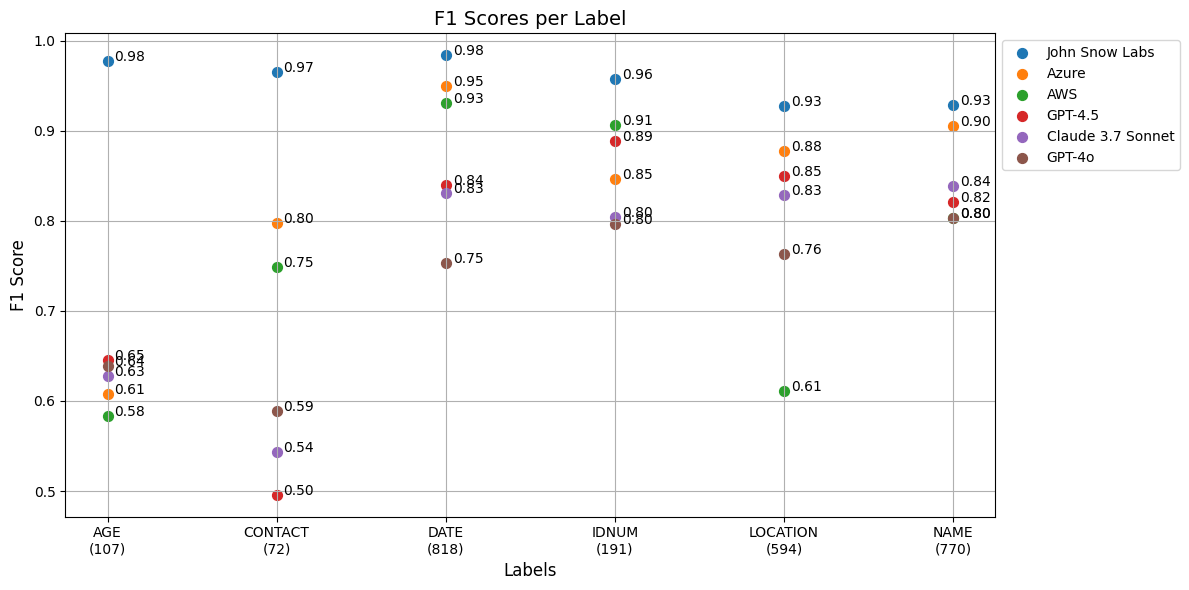

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_f1_scores(df):
    labels = sorted([label for label in df['token_label'].unique() if label != 'O'])

    plt.figure(figsize=(12, 6))

    legend_names = {
        'john_snow_labs_token_label': 'John Snow Labs',
        'azure_token_label': 'Azure',
        'aws_token_label': 'AWS',
        'gpt_45_token_label': 'GPT-4.5',
        'gpt4_token_label': 'GPT-4o',
        'claude_token_label': 'Claude 3.7 Sonnet'
    }

    for col in ['john_snow_labs_token_label', 'azure_token_label', 'aws_token_label', 'gpt_45_token_label', 'claude_token_label', 'gpt4_token_label']:
        f1_scores = []
        for label in labels:
            report = classification_report(df['token_label'], df[col], output_dict=True)
            f1 = report.get(label, {}).get('f1-score', 0)
            f1_scores.append(f1)

        plt.scatter(labels, f1_scores, label=legend_names[col], marker='o', s=50)

        for i, txt in enumerate(f1_scores):
            plt.annotate(f"{txt:.2f}", (labels[i], f1_scores[i]), textcoords="offset points", xytext=(5,0), ha='left')

    # Calculate support for each label
    support_counts = df['token_label'].value_counts()

    # Customize x-axis ticks with support counts
    x_ticks = [f"{label}\n({support_counts.get(label, 0)})" for label in labels]
    plt.xticks(labels, x_ticks)

    plt.xlabel("Labels", fontsize=12)
    plt.ylabel("F1 Score", fontsize=12)
    plt.title("F1 Scores per Label", fontsize=14)
    plt.grid(True)

    # Move the legend outside the plot
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('f1_scores_per_label.png')
    plt.show()

plot_f1_scores(token_pred_df)

### PHI Or Non-PHI

The de-identification task is crucial in ensuring the privacy of sensitive data. In this context, the primary focus is not on the specific labels of PHI entities but on whether they are successfully detected. When we evaluate the results based on whether the entities are classified as PHI or non-PHI, the outcomes are as follows.

In [ ]:
phi_token_df = token_pred_df.copy()
phi_token_df.token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.token_label]
phi_token_df.john_snow_labs_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.john_snow_labs_token_label]
phi_token_df.azure_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.azure_token_label]
phi_token_df.aws_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.aws_token_label]
phi_token_df.gpt4_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.gpt4_token_label]
phi_token_df.claude_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.claude_token_label]
phi_token_df.gpt_45_token_label = ["PHI" if i != "O" else "Non-PHI" for i in phi_token_df.gpt_45_token_label]

phi_token_df

,doc_id,text,token_begin,token_end,token,token_label,john_snow_labs_token_label,azure_token_label,aws_token_label,gpt4_token_label,claude_token_label,gpt_45_token_label
0,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,1,10,957770228,PHI,PHI,PHI,PHI,PHI,PHI,PHI
1,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,11,14,FIH,PHI,PHI,PHI,Non-PHI,PHI,Non-PHI,Non-PHI
2,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,15,22,0408267,PHI,PHI,PHI,PHI,PHI,PHI,PHI
3,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,23,33,46769/5v7d,PHI,PHI,PHI,PHI,PHI,PHI,Non-PHI
4,1,\n957770228\nFIH\n0408267\n46769/5v7d\n237890\...,34,40,237890,PHI,PHI,PHI,PHI,PHI,PHI,PHI
...,...,...,...,...,...,...,...,...,...,...,...,...
45167,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",608,620,644.508.1141,PHI,PHI,PHI,PHI,PHI,PHI,PHI
45168,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",621,622,1,Non-PHI,Non-PHI,PHI,Non-PHI,Non-PHI,Non-PHI,Non-PHI
45169,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",623,625,of,Non-PHI,Non-PHI,Non-PHI,Non-PHI,Non-PHI,Non-PHI,Non-PHI
45170,48,"6509414988 Theophilus\n\nAniceto ,\n\nUNIVERSI...",626,628,87,Non-PHI,Non-PHI,Non-PHI,Non-PHI,Non-PHI,Non-PHI,Non-PHI


In [ ]:
from sklearn.metrics import classification_report

print("Healthcare NLP:")
print(classification_report(phi_token_df["token_label"], phi_token_df["healthcare_nlp_token_label"]))

Healthcare NLP:
              precision    recall  f1-score   support

     Non-PHI       1.00      1.00      1.00     42620
         PHI       0.96      0.97      0.96      2552

    accuracy                           1.00     45172
   macro avg       0.98      0.98      0.98     45172
weighted avg       1.00      1.00      1.00     45172



In [ ]:
print("Azure:")
print(classification_report(phi_token_df["token_label"], phi_token_df["azure_token_label"]))

Azure:
              precision    recall  f1-score   support

     Non-PHI       1.00      0.99      0.99     42620
         PHI       0.91      0.92      0.91      2552

    accuracy                           0.99     45172
   macro avg       0.95      0.96      0.95     45172
weighted avg       0.99      0.99      0.99     45172



In [ ]:
print("AWS:")
print(classification_report(phi_token_df["token_label"], phi_token_df["aws_token_label"]))

AWS:
              precision    recall  f1-score   support

     Non-PHI       0.99      0.99      0.99     42620
         PHI       0.81      0.85      0.83      2552

    accuracy                           0.98     45172
   macro avg       0.90      0.92      0.91     45172
weighted avg       0.98      0.98      0.98     45172



In [24]:
print("Claude 3.7 Sonnet:")
print(classification_report(phi_token_df["token_label"], phi_token_df["claude_token_label"]))

Claude 3.7 Sonnet:
              precision    recall  f1-score   support

     Non-PHI       0.99      0.99      0.99     42620
         PHI       0.81      0.84      0.83      2552

    accuracy                           0.98     45172
   macro avg       0.90      0.92      0.91     45172
weighted avg       0.98      0.98      0.98     45172



In [ ]:
print("GPT-4o:")
print(classification_report(phi_token_df["token_label"], phi_token_df["gpt4_token_label"]))

GPT-4o:
              precision    recall  f1-score   support

     Non-PHI       0.99      0.99      0.99     42620
         PHI       0.81      0.77      0.79      2552

    accuracy                           0.98     45172
   macro avg       0.90      0.88      0.89     45172
weighted avg       0.98      0.98      0.98     45172



In [ ]:
print("GPT-4.5:")
print(classification_report(phi_token_df["token_label"], phi_token_df["gpt_45_token_label"]))

GPT-4.5:
              precision    recall  f1-score   support

     Non-PHI       0.99      0.99      0.99     42620
         PHI       0.81      0.87      0.84      2552

    accuracy                           0.98     45172
   macro avg       0.90      0.93      0.91     45172
weighted avg       0.98      0.98      0.98     45172



**Let's visualize the Precision, Recall and F1-Scores for PHI labels on a single plot.**

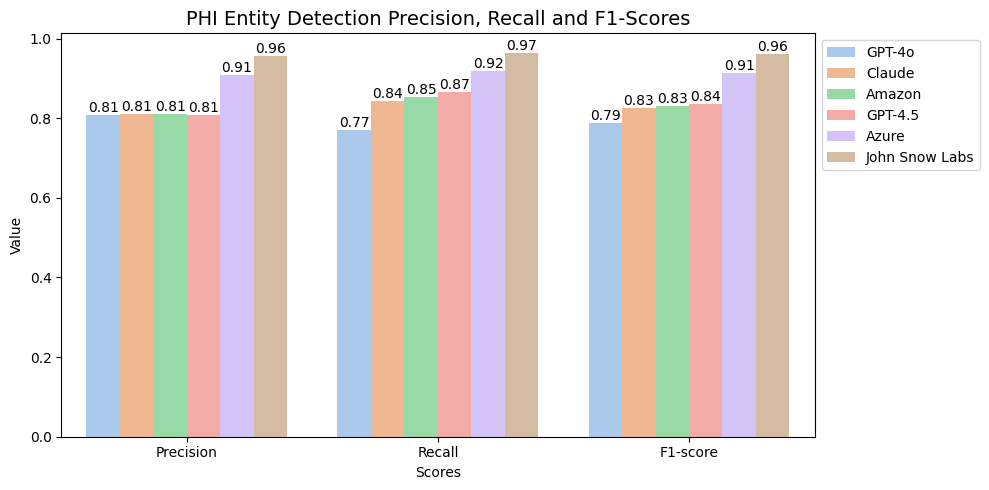

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phi_f1_scores_grouped(df):
    # Define the models and rename them
    models = {
        'john_snow_labs_token_label': 'John Snow Labs',
        'azure_token_label': 'Azure',
        'aws_token_label': 'Amazon',
        'claude_token_label': 'Claude',
        'gpt4_token_label': 'GPT-4o',
        'gpt_45_token_label': 'GPT-4.5'
    }

    # Extract scores for PHI label
    scores_data = []
    for model_col, model_name in models.items():
        report = classification_report(df['token_label'], df[model_col], output_dict=True, zero_division=0)
        precision = report.get('PHI', {}).get('precision', 0)
        recall = report.get('PHI', {}).get('recall', 0)
        f1 = report.get('PHI', {}).get('f1-score', 0)
        scores_data.extend([
            {'Model': model_name, 'Score': 'Precision', 'Value': precision},
            {'Model': model_name, 'Score': 'Recall', 'Value': recall},
            {'Model': model_name, 'Score': 'F1-score', 'Value': f1}
        ])

    scores_df = pd.DataFrame(scores_data)

    # Plotting
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Score', y='Value', hue='Model', data=scores_df, hue_order=['GPT-4o', 'Claude', 'Amazon', 'GPT-4.5', 'Azure', 'John Snow Labs' ], palette="pastel")
    plt.title('PHI Entity Detection Precision, Recall and F1-Scores', fontsize=14)
    plt.xlabel('Scores')
    plt.ylabel('Value')
    plt.xticks(rotation=0)

    # Add value annotations
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:  # Avoid displaying 0.00
            plt.gca().annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', fontsize=10)

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # Move the legend outside the plot
    plt.tight_layout()
    plt.savefig('phi_detection_scores.png', bbox_inches='tight', dpi=300)
    plt.show()


plot_phi_f1_scores_grouped(phi_token_df)

# Price Analysis Of The Tools

When handling large volumes of clinical notes, cost becomes a key consideration. Since such small datasets are rare in real-world applications, we estimated the expenses for these tools based on processing 1 million unstructured clinical notes, with each document averaging around 5,250 characters.

**[Amazon Comprehend Medical Pricing:](https://aws.amazon.com/comprehend/medical/pricing/)** According to the price calculator, obtaining PHI predictions for 1M documents, with an average of 5,250 characters per document, costs \$14,525.

**[Open AI GPT-4o Pricing:](https://openai.com/api/pricing/)** Processing 1M documents costs approximately \$21,400.

**[Open AI GPT-4.5 Pricing](https://platform.openai.com/docs/pricing)** Processing 1M documents costs approximately $281,458.

**[Anthropic Claude 3.7 Sonnet:](https://www.anthropic.com/pricing#anthropic-api)** Processing 1M documents costs approximately \$23,330.

**[Healthcare NLP Pricing:](https://aws.amazon.com/marketplace/pp/prodview-kz47umgfezydo)** When using John Snow Labs-Healthcare NLP Prepaid product on an EC2–32 CPU (c6a.8xlarge at \$1,2 per hour) machine, obtaining the de-identification codes for PHI entities from approximately 48 documents takes around 39.4 seconds. Based on this, processing 1M documents and de-identifying the PHI entities would take about 13680 minutes (228 hours (approximately 9.5 days), but with proper scaling, it can be completed in just one day), costing \$273 for infrastructure and \$2145 for the license (considering a 1-month license price of \$7,000). Thus, the total cost for Healthcare NLP is approximately $2418.

**[Azure Health Data Services Pricing:](https://azure.microsoft.com/en-us/pricing/calculator/)** The price for Azure Health Data Services could not be verified. You can refer to the pricing calculator available on the Azure website for more details.

### Tool Cost Comparison

| **Tool**                     | **Cost (USD)**               |
|------------------------------|-----------------------------|
| **Healthcare NLP**           | $2,418                      |
| **Amazon Comprehend Medical** | $14,525                     |
| **OpenAI GPT-4o**            | $21,400                     |
| **Anthropic Claude 3.7 Sonnet** | $23,330                     |
| **OpenAI GPT-4.5**            | $281,458                   |
| **Azure Health Data Services** | Couldn't verify the price  |

# Conclusion

In this study, we compared the performance of John Snow Labs, Amazon Comprehend Medical, Azure Health Data Services, OpenAI GPT-4o, GPT-4.5 and Anthropic Claude 3.7 Sonnet tools on a ground truth dataset annotated by medical experts. The results were evaluated from two perspectives: chunk-level and token-level.

- The **chunk-level evaluation** revealed that **John Snow Labs delivered the highest accuracy in capturing entities while minimizing omissions**. Following closely behind was Azure Health Data Services in second place, with Claude 3.7 Sonnet taking third. Amazon Comprehend Medical ranked fourth, GPT-4.5 came in fifth, and GPT-4o trailed in sixth.
- The **token-level evaluation** revealed that **John Snow Labs achieved the best results in terms of precision, recall, and F1 score**, with Azure Health Data Services, GPT-4.5, Amazon Comprehend Medical, Claude 3.7 Sonnet, and GPT-4o trailing behind in that order.
- **Adaptability of Tools:** One of the key differences among these tools is their level of adaptability. While Azure Health Data Services, Amazon Comprehend Medical, OpenAI GPT-4o & GPT-4.5, and Anthropic Claude 3.7 Sonnet model are API-based, black-box cloud solutions that do not allow modifications or customization of results, the John Snow Labs offers a highly flexible approach. Its de-identification pipeline can be implemented with just two lines of code, and users can easily customize outputs by modifying the pipeline’s stages to suit specific requirements.
- **Cost-Effectiveness:** Among the evaluated tools (excluding Azure, whose pricing couldn’t be verified), **John Snow Labs emerges as the most cost-effective option for large-scale clinical de-identification**. While API-based services like Amazon Comprehend Medical, OpenAI’s GPT-4o, Anthropic Claude, and especially GPT-4.5 incur costs per request — quickly adding up at scale — John Snow Labs offers a locally deployable solution with fixed pricing. This makes it far more budget-friendly, particularly when processing vast volumes of data. Notably, despite GPT-4.5’s high performance potential, its estimated cost ranks among the highest, making it less suitable for cost-sensitive healthcare applications where both affordability and scalability are crucial.

In summary, the John Snow Labs consistently outperformed Azure Health Data Services, Amazon Comprehend Medical, OpenAI GPT-4o & GPT-4.5 , and Anthropic Claude 3.7 Sonnet model in both chunk-level and token-level evaluations, achieving the highest precision, recall, and F1 scores while minimizing missed entities. Beyond accuracy, its adaptability sets it apart, unlike Azure, Amazon, GPT-4o, GPT-4.5, and Claude 3.7 Sonnet which are black-box API solutions with no customization options, John Snow Labs allows users to modify its deidentification pipeline to meet specific needs. Additionally, it proves to be the most cost-effective solution, offering substantial savings compared to cloud-based alternatives that charge per request.

You can read the blogpost of this notebook here: https://medium.com/p/47f17d185c87